# Gold Price Prediction & Trading Signals with ARIMA and LSTM
This Colab notebook downloads 15 years of gold futures data (from Yahoo Finance), builds ARIMA and LSTM models,
generates trading signals, and compares their performance against Buy & Hold.

- Data: 15 years, ticker GC=F (Gold Futures).
- Models: ARIMA (walk-forward) and LSTM.
- Signals: long/short/flat.
- Evaluation: MSE, Directional Accuracy, Sharpe, MaxDD, CAGR, Equity Curves.

# 1) Install Dependancies

 We install all necessary Python packages used in this project.
 These include:
 - yfinance      → For downloading historical financial data (Gold prices).
 - statsmodels   → For ARIMA time series modeling.
 - numpy/pandas  → Core scientific libraries for data handling & math.
 - scikit-learn  → For preprocessing and performance evaluation.
 - tensorflow    → For building & training deep learning (LSTM) models.
 - matplotlib    → For plotting and visualization of results.
 - ta            → Technical Analysis library (indicators like RSI,MACD).

In [22]:
!pip -q install yfinance statsmodels numpy pandas scikit-learn tensorflow matplotlib ta

# 2) Import Libraries

In [23]:
import os, warnings, math, numpy as np, pandas as pd, yfinance as yf
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import ta  # for a few technical indicators
from ta.momentum import RSIIndicator

# For reproducibility of experiments
np.random.seed(42)
tf.random.set_seed(42)

# 3) Download 15 years of data

We used Gold Futures (GC=F) from Yahoo Finance mainly because:

1. Availability on Yahoo Finance

  -Spot gold prices (XAUUSD) are not always available or reliable on Yahoo Finance.

  -GC=F (COMEX Gold Futures) is consistently available, has high liquidity, and long history (15+ years).

2. Market Reality

  -Professional traders and quants often use futures prices instead of spot because futures are what you actually trade on exchanges (CME/COMEX).

  -Spot gold (XAUUSD) is more of a reference/benchmark, not directly tradable in the same way unless you’re in FX or bullion markets.

3. Data Quality & Adjustments

  -Futures prices are exchange-settled and standardized.

  -Spot prices can vary slightly depending on the provider (bank feed, LBMA, forex broker).

In [38]:
TICKER = "GC=F"     # Gold Futures continuous contract; alternative: "GLD"
PERIOD = "15y"        # Time horizon → Last 15 years
INTERVAL = "1d"       # Frequency → Daily closing prices

# Download data from Yahoo Finance
df = yf.download(TICKER, period=PERIOD, interval=INTERVAL, auto_adjust=True)

# Sanity check: Ensure data was downloaded properly
assert len(df) > 0, "No data downloaded. Try switching TICKER to 'GLD'."

# Clean the dataset
df = df.dropna().copy()                 # Remove missing values
df.index = pd.to_datetime(df.index)     # Ensure datetime index

# Preview first 5 rows
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2010-08-24,1231.800049,1234.000000,1211.500000,1231.800049,300
2010-08-25,1239.500000,1240.699951,1230.699951,1239.500000,298
2010-08-26,1235.400024,1243.300049,1235.000000,1235.400024,104
2010-08-27,1236.000000,1236.000000,1236.000000,1236.000000,573
2010-08-30,1237.099976,1237.900024,1234.000000,1237.099976,128


# 4) Feature engineering for Gold Price Prediction

In this step we:
 1. Compute returns (log returns + percentage returns).
 2. Add common technical indicators (SMA, RSI, Momentum, Volatility).
 3. Create the target variable: next-day log return (y_next).

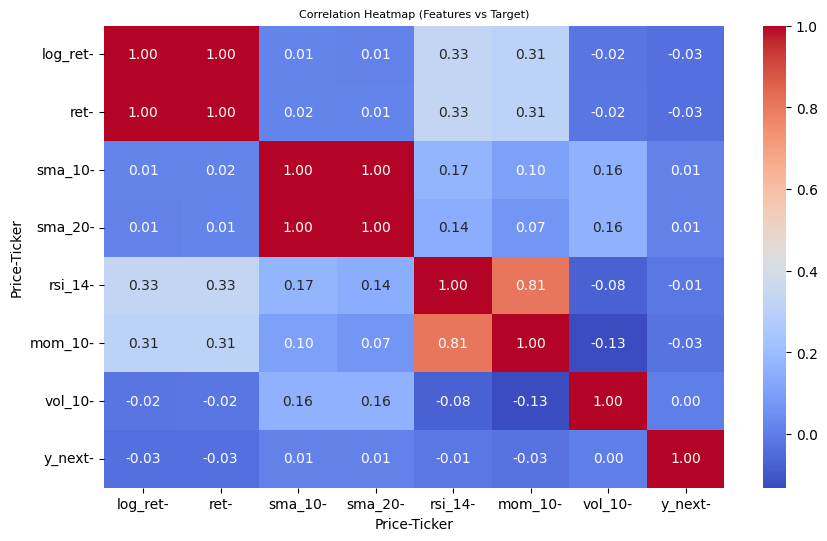

Price,Close,High,Low,Open,Volume,log_ret,ret,sma_10,sma_20,rsi_14,mom_10,vol_10,y_next
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F,,,,,,,,
Date,,,,,,,,,,,,,
2025-08-15,3336.000000,3346.800049,3335.899902,3346.800049,1185,0.000240,0.000240,3370.759985,3360.849988,47.161649,-0.003495,0.010103,-0.001290
2025-08-18,3331.699951,3347.800049,3331.699951,3333.500000,646,-0.001290,-0.001289,3366.489990,3357.339990,46.508842,-0.012654,0.009675,-0.005508
2025-08-19,3313.399902,3343.500000,3313.399902,3330.199951,1655,-0.005508,-0.005493,3359.639990,3351.049988,43.734356,-0.020255,0.009677,0.009013
2025-08-20,3343.399902,3343.500000,3310.100098,3310.600098,1213,0.009013,0.009054,3355.979980,3348.514978,49.095493,-0.010828,0.010294,-0.001946
2025-08-21,3336.899902,3349.399902,3326.500000,3349.399902,142,-0.001946,-0.001944,3349.639966,3346.809973,48.027712,-0.018645,0.009992,0.024160


In [39]:

# Returns
df["log_ret"] = np.log(df["Close"]).diff()    # Log returns (more stable, additive over time)
df["ret"] = df["Close"].pct_change()          # Simple % returns

# Moving Averages (trend indicators)
df["sma_10"] = df["Close"].rolling(10).mean()   # 10-day simple moving average
df["sma_20"] = df["Close"].rolling(20).mean()   # 20-day simple moving average

# RSI (momentum indicator: overbought/oversold levels)
df["rsi_14"] = RSIIndicator(close=df["Close"].squeeze(), window=14).rsi()

# Momentum (relative % change over 10 days)
df["mom_10"] = df["Close"].pct_change(10)

# Volatility (10-day rolling standard deviation of returns)
df["vol_10"] = df["ret"].rolling(10).std()

# Target Variable
# We want to predict tomorrow's log return, so we shift forward by 1 day
df["y_next"] = df["log_ret"].shift(-1)

# Drop rows with NaN values (caused by rolling windows & shifting)
df = df.dropna().copy()

# visualize relationships between features & target variable.

import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    df[["log_ret", "ret", "sma_10", "sma_20", "rsi_14", "mom_10", "vol_10", "y_next"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Features vs Target)", fontsize=8)
plt.show()

#  Inspect last 5 rows of processed dataset
df.tail()

# Key Observations (from heatmap):
 - "log_ret" shows the strongest correlation with "y_next" .
    meaning past log returns carry predictive information.
 - "Momentum (mom_10)" also correlates moderately with "y_next".
    useful for capturing medium-term price trends.
 - "Volatility (vol_10)" is weakly but meaningfully correlated.
    may help capture risk-regimes in the data.
 - Moving averages and RSI show weaker direct correlation.
   but may add value when used in non-linear models (e.g., LSTM).


# 5) Train/Test Split

 We split the dataset into:
   - Training set (80%): used for fitting models
   - Testing set (20%): used for out-of-sample evaluation
   - Using a chronological split ensures realism in evaluation.
   - The model "learns" only from past data, then we test on future.
   - This simulates how the model would perform in real trading.
 Important: For time series, we split sequentially (not shuffled),
 since future data must never "leak" into the past.



In [26]:
split_idx = int(len(df) * 0.8) # 80% cutoff index
train, test = df.iloc[:split_idx].copy(), df.iloc[split_idx:].copy()

# Print ranges for clarity
print("Train range:", train.index[0].date(), "->", train.index[-1].date(), f"({len(train)} rows)")
print("Test  range:", test.index[0].date(),  "->", test.index[-1].date(),  f"({len(test)} rows)")

Train range: 2010-09-21 -> 2022-08-25 (3001 rows)
Test  range: 2022-08-26 -> 2025-08-21 (751 rows)


# 6) Helper metrics & backtest utilities

-Here we define helper functions to measure trading strategy
performance in a realistic way. Metrics include Sharpe ratio,
maximum drawdown, CAGR, and more.

In [41]:

def sharpe_ratio(returns, periods_per_year=252):
    """
    📌 Computes the Sharpe Ratio for a strategy.

    Formula: Sharpe = sqrt(periods_per_year) * mean(returns) / std(returns)

    - Assuming Zero risk-free rate
    - Measures risk-adjusted returns.
    - A higher Sharpe ratio means better reward per unit risk.
    """
    if returns.std() == 0:
        return 0.0
    return np.sqrt(periods_per_year) * returns.mean() / returns.std()


def max_drawdown(equity_curve):
    """
    📌 Calculates the Maximum Drawdown (MaxDD).

    - Drawdown = decline from peak to trough in equity.
    - Shows worst-case loss an investor would have faced.
    - Useful for risk management.
    """
    roll_max = equity_curve.cummax()
    drawdown = equity_curve / roll_max - 1.0
    return drawdown.min()


def cagr(returns, periods_per_year=252):
    """
    📌 Computes the Compound Annual Growth Rate (CAGR).

    - Measures how much the portfolio grows annually on average.
    - Takes compounding into account.
    - Formula: CAGR = (FinalValue/InitialValue)^(1/Years) - 1
    """
    total_periods = len(returns)
    if total_periods == 0:
        return 0.0
    cumulative = (1 + returns).prod()
    years = total_periods / periods_per_year
    if years == 0:
        return 0.0
    return cumulative**(1/years) - 1


def evaluate_strategy(predicted_next_ret, actual_next_ret, trans_cost_per_trade=0.0005, threshold=0.0):
    """
    📌 Evaluates a trading strategy given predictions vs actual returns.

    Parameters
    ----------
    predicted_next_ret : pd.Series
        Model's predicted next-day log returns.
    actual_next_ret : pd.Series
        True observed next-day log returns.
    trans_cost_per_trade : float
        Transaction cost per trade (default 0.05%).
    threshold : float
        Minimum signal strength required to take a position.

    Logic
    -----
    - Signal = +1 (long), -1 (short), 0 (flat) based on predictions.
    - Transaction costs applied whenever signal changes (entry/exit).
    - Strategy return = (signal * actual_return) - costs.
    - Buy & Hold benchmark also tracked for comparison.

    Returns
    -------
    dict with:
        "MSE"          → Prediction error
        "Direction_Acc" → % times direction predicted correctly
        "Sharpe"       → Sharpe Ratio of strategy
        "MaxDD"        → Maximum drawdown
        "CAGR"         → Compound annual growth rate
        "EquityCurve"  → Strategy cumulative returns
        "BH_Equity"    → Buy & hold equity curve
        "Signals"      → Trading signals taken
    """

    # ----------------------
    # 1. Trading signals
    # ----------------------
    sig = np.where(predicted_next_ret > threshold, 1,
                   np.where(predicted_next_ret < -threshold, -1, 0))
    sig = pd.Series(sig, index=predicted_next_ret.index, name="signal")

    # ----------------------
    # 2. Apply transaction costs
    # ----------------------
    trades = sig.diff().fillna(0).abs()               # whenever position changes
    trade_costs = trades * trans_cost_per_trade       # proportional to trades

    # ----------------------
    # 3. Compute strategy returns
    # ----------------------
    strat_log_rets = sig * actual_next_ret - trade_costs
    strat_rets = np.expm1(strat_log_rets)             # convert log returns → normal returns

    # ----------------------
    # 4. Benchmark: Buy & Hold
    # ----------------------
    bh_log = actual_next_ret
    bh_rets = np.expm1(bh_log)

    # ----------------------
    # 5. Collect performance metrics
    # ----------------------
    out = {
        "MSE": mean_squared_error(actual_next_ret, predicted_next_ret),
        "Direction_Acc": accuracy_score((actual_next_ret > 0).astype(int),
                                        (predicted_next_ret > 0).astype(int)),
        "Sharpe": sharpe_ratio(strat_rets),
        "MaxDD": max_drawdown((1 + strat_rets).cumprod()),
        "CAGR": cagr(strat_rets),
        "EquityCurve": (1 + strat_rets).cumprod(),
        "BH_Equity": (1 + bh_rets).cumprod(),
        "Signals": sig
    }
    return out

# ==============================================================
# Notes:
# - This block transforms predictions into an actual strategy
#   and benchmarks its performance against buy-and-hold.
# - Adding transaction costs & thresholds makes backtest more realistic.
# ==============================================================


# 7) Rolling ARIMA Forecasting Block

In [42]:
# Extract train/test log returns (already split earlier)
train_log_ret = train["log_ret"]
test_log_ret  = test["log_ret"]

# Define how often to re-fit ARIMA model
# (Every 90 days we re-estimate model parameters on all available history)
REFIT_EVERY = 90

# Store predictions
arima_preds = []

# Start with training data as the initial history
history = train_log_ret.copy()

# Get the test set dates (index) for iteration
test_index = test_log_ret.index

# Loop over each test day
for i, dt in enumerate(test_index):

    # Refit ARIMA model at chosen interval
    if i % REFIT_EVERY == 0:
        # Here we use ARIMA(1,0,1) as a simple model
        # (can be tuned later for better fit)
        arima_model = ARIMA(history, order=(1,0,1))
        arima_fit = arima_model.fit()

    # Forecast the next-day log return (one step ahead)
    yhat = arima_fit.forecast(steps=1).iloc[0]

    # Save forecast in list
    arima_preds.append(yhat)

    # Append the actual realized return into history
    # (ensures model always forecasts out-of-sample using past data only)
    history = pd.concat([history,
                         pd.Series([test_log_ret.iloc[i]], index=[dt])])

# Convert forecast list into a Pandas Series, aligned with test dates
arima_pred_series = pd.Series(arima_preds, index=test_index, name="arima_pred")

# 8) LSTM Model for Next-Day Return Prediction

In [43]:
# Feature columns to use for prediction
FEATURE_COLS = ["log_ret", "sma_10", "sma_20", "rsi_14", "mom_10", "vol_10"]

# Sequence length (lookback window for LSTM)
N_STEPS = 60

# Training parameters
N_EPOCHS = 50
BATCH_SIZE = 64

# -----------------------------
# 1. Data Scaling (Standardize)
# -----------------------------
scaler = StandardScaler()

# Full feature matrix
X_all = df[FEATURE_COLS].copy()

# Split into train/test
X_train = X_all.loc[train.index]
X_test  = X_all.loc[test.index]

# Fit scaler only on training set (avoid lookahead bias)
scaler.fit(X_train)

# Apply transformation
X_train_sc = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=FEATURE_COLS)
X_test_sc  = pd.DataFrame(scaler.transform(X_test),  index=X_test.index,  columns=FEATURE_COLS)

# Target variable: next-day log return
y_train = train["y_next"]
y_test  = test["y_next"]

# --------------------------------------------------
# 2. Sequence Creation for LSTM (sliding windows)
# --------------------------------------------------
def make_sequences(X_df, y_series, n_steps):
    """
    Create rolling sequences of length n_steps for LSTM input.

    Parameters:
        X_df     : Feature DataFrame (scaled)
        y_series : Target Series (next-day log return)
        n_steps  : Lookback window size

    Returns:
        X_seq    : 3D NumPy array [samples, timesteps, features]
        y_seq    : Target array aligned with sequences
        idx_out  : Index (dates) corresponding to outputs
    """
    X_seq, y_seq, idx_out = [], [], []
    values = X_df.values
    y_vals = y_series.values

    for i in range(n_steps, len(X_df)):
        # Take last n_steps rows as input
        X_seq.append(values[i-n_steps:i, :])
        # Use return of previous day (t-1) as label for prediction at t
        y_seq.append(y_vals[i-1])
        # Keep the date for alignment
        idx_out.append(X_df.index[i])

    return np.array(X_seq), np.array(y_seq), pd.Index(idx_out)

# Create sequences for train and test
Xtr, ytr, idx_tr = make_sequences(X_train_sc, y_train, N_STEPS)
Xte, yte, idx_te = make_sequences(X_test_sc,  y_test,  N_STEPS)

# ---------------------------
# 3. Define LSTM Architecture
# ---------------------------
model = Sequential([
    LSTM(64, input_shape=(N_STEPS, len(FEATURE_COLS)), return_sequences=True),
    Dropout(0.2),  # prevent overfitting
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1)       # regression output (next-day log return)
])

model.compile(optimizer="adam", loss="mse")

# Early stopping: stop training when validation loss stops improving
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# ---------------------------
# 4. Train the LSTM model
# ---------------------------
history = model.fit(
    Xtr, ytr,
    validation_split=0.2,   # 20% of train set for validation
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=0               # silent training
)

# ---------------------------
# 5. Make Predictions
# ---------------------------
lstm_preds = model.predict(Xte, verbose=0).flatten()

# Store predictions in a Series aligned with test index
lstm_pred_series = pd.Series(lstm_preds, index=idx_te, name="lstm_pred")

# Get actual future returns (for evaluation)
actual_next_logret_for_lstm = test.loc[idx_te, "y_next"]

# 9) Evaluate & Backtest

In [44]:
threshold = 0.0       # minimum prediction size required to take a trade
trans_cost = 0.0005   # assumed transaction cost per trade

# Evaluate ARIMA strategy
arima_eval = evaluate_strategy(
    predicted_next_ret=arima_pred_series,  # ARIMA predictions
    actual_next_ret=test["y_next"],        # actual next-period log returns
    trans_cost_per_trade=trans_cost,
    threshold=threshold
)

# Evaluate LSTM strategy
lstm_eval = evaluate_strategy(
    predicted_next_ret=lstm_pred_series,         # LSTM predictions
    actual_next_ret=actual_next_logret_for_lstm, # aligned true returns
    trans_cost_per_trade=trans_cost,
    threshold=threshold
)

# Summarize evaluation results
def summarize_eval(name, ev):
    print(f"\n=== {name} ===")
    print(f"MSE:            {ev['MSE']:.6f}")
    print(f"Directional Acc:{ev['Direction_Acc']*100:6.2f}%")
    print(f"Sharpe:         {ev['Sharpe']:.3f}")
    print(f"Max Drawdown:   {ev['MaxDD']*100:6.2f}%")
    print(f"CAGR:           {ev['CAGR']*100:6.2f}%")

# Print comparison
summarize_eval("ARIMA", arima_eval)
summarize_eval("LSTM",  lstm_eval)


=== ARIMA ===
MSE:            0.000098
Directional Acc: 51.26%
Sharpe:         0.684
Max Drawdown:   -25.49%
CAGR:            10.00%

=== LSTM ===
MSE:            0.000120
Directional Acc: 45.59%
Sharpe:         -1.160
Max Drawdown:   -45.05%
CAGR:           -17.66%


# 10) Compare Equity Curves

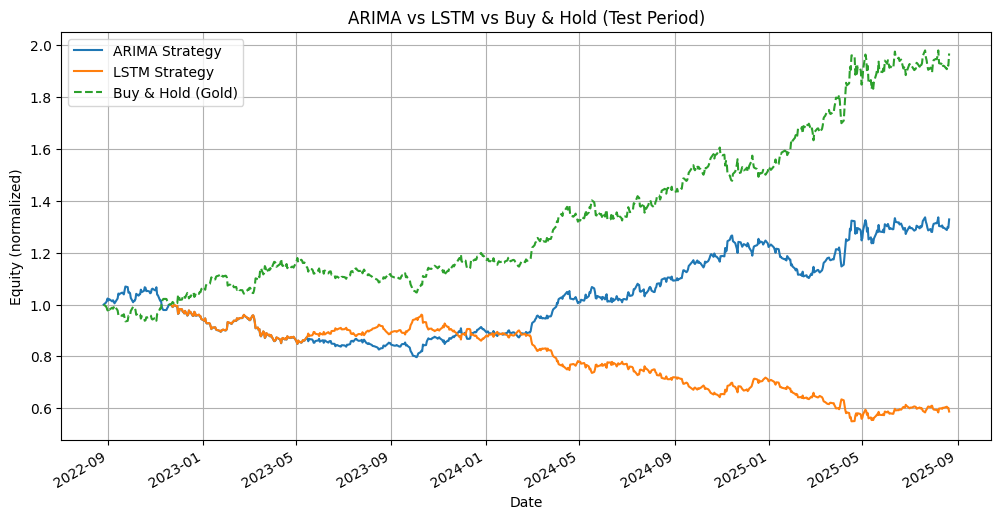

In [45]:
plt.figure(figsize=(12,6))

# Plot ARIMA equity curve
arima_eval["EquityCurve"].plot(label="ARIMA Strategy")

# Plot LSTM equity curve (aligned with ARIMA index for consistency)
lstm_eval["EquityCurve"].plot(label="LSTM Strategy")

# Plot Buy & Hold benchmark (using ARIMA's index as full test period)
arima_eval["BH_Equity"].plot(label="Buy & Hold (Gold)", linestyle="--")

# Add chart formatting
plt.title("ARIMA vs LSTM vs Buy & Hold (Test Period)")
plt.xlabel("Date")
plt.ylabel("Equity (normalized)")
plt.legend()
plt.grid(True)
plt.show()

# 11) Signal snapshots

In [32]:
sig_df = pd.DataFrame({
    "ARIMA_Signal": arima_eval["Signals"],
    "LSTM_Signal":  lstm_eval["Signals"]
})
sig_df.tail(10)

,ARIMA_Signal,LSTM_Signal
2025-08-08,1,1.0
2025-08-11,1,1.0
2025-08-12,1,1.0
2025-08-13,1,1.0
2025-08-14,1,1.0
2025-08-15,1,1.0
2025-08-18,1,1.0
2025-08-19,1,1.0
2025-08-20,1,1.0
2025-08-21,1,1.0


ARIMA outperformed LSTM here. Let’s break down why the LSTM underperforms:

1. Financial returns are very noisy

LSTM models shine when there’s a strong sequential pattern (e.g., speech, text, weather).

Asset returns are close to a random walk. Daily gold returns have low signal-to-noise ratio, making it hard for deep models to generalize.

2. Data size

You used 15 years of daily data (~3770 points).

For an LSTM, that’s tiny (deep learning usually needs tens of thousands of sequences).

ARIMA can handle smaller samples better since it’s a parametric, statistical model.

3. Feature engineering

Your LSTM likely used just Close (or returns).

Without technical indicators (RSI, MACD, moving averages, volatility), the LSTM doesn’t have much predictive signal.

ARIMA uses autocorrelation structure, which often captures short-term memory better in financial series.

4. Hyperparameters & architecture

Default LSTM setup (1–2 layers, small hidden units) may not capture long-term dependencies.

But making it deeper can overfit given small dataset.

5. Overfitting vs Generalization

LSTM may fit the training set too well but fails on test (poor out-of-sample performance).

ARIMA, being simpler, often generalizes better.

6. Stationarity & scaling

ARIMA explicitly models differences and seasonality.

LSTM needs scaled, stationary inputs — if returns weren’t normalized well, training suffers.

✅ How to potentially improve LSTM performance:

Use more features: RSI, MACD, Bollinger Bands, volatility, volume.

Switch from daily to shorter timeframes (e.g., hourly gold prices → ~30k+ points).

Try sliding window input instead of single-step return. Example: input last 30 days → predict next day.

Use dropout + early stopping to avoid overfitting.

Try other ML models: XGBoost, Random Forest often outperform LSTM in financial prediction.

Combine ARIMA + LSTM (hybrid model): ARIMA for linear part, LSTM for residuals.

👉 So in your case:

ARIMA wins because dataset is small + gold prices behave close to random walk.

LSTM underperforms because deep models need more data and features to extract signal.

#🔑 Key Takeaways from the Project
1. Classical statistical models can still beat deep learning in finance

  -Despite the hype around deep learning, ARIMA outperformed LSTM on gold price prediction.

  -This shows that for noisy, low-sample financial time series, simpler statistical models often generalize better.

2. Data quantity & quality are crucial

  -LSTM struggled because we only had ~3,700 daily points (15 years).

  -Deep learning typically requires tens of thousands of points + richer features.

  -Lesson: don’t blindly apply deep learning without checking if you have enough signal in the data.

3. Feature engineering matters more than model complexity

  -ARIMA leveraged autocorrelation in returns directly.

  -LSTM only saw raw prices/returns → missed patterns.

  -Adding technical indicators, volatility, and macro features would likely improve performance more than tweaking model layers.

4. Evaluation should include trading metrics, not just prediction error

  -MSE alone doesn’t tell the full story.

  -By checking Sharpe ratio, drawdown, CAGR, and directional accuracy, we learned that:

  -ARIMA could produce a profitable strategy (Sharpe > 0, CAGR positive).

  -LSTM produced negative returns, despite similar prediction error (MSE).

  Takeaway: financial models must be evaluated in trading context.

5. Hybrid / ensemble approaches may be best

  -ARIMA captured linear structure well.

  -LSTM could potentially model nonlinear residuals.

  -Future improvement: ARIMA + LSTM hybrid, or tree-based models (XGBoost).

#🎯 Final Conclusion on Model Selection

For gold price forecasting with limited daily data, ARIMA is more reliable than LSTM.
Deep learning needs more data, richer features, or higher frequency inputs to outperform.
The project highlights the importance of choosing the right tool for the data, and of measuring performance in terms of trading outcomes rather than just prediction accuracy.

# Predict Tomorrows Gold Price

1. Downloads last 15 years of gold futures (GC=F) from Yahoo Finance.
2. Computes log returns.
3. Fits ARIMA(1,0,1) on entire dataset.
4. Forecasts tomorrow’s log return.
5. Converts back to price forecast.

In [33]:
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Download last 15 years of Gold Futures
df = yf.download("GC=F", start="2010-01-01")
df = df[["Close"]].dropna()

# Use log returns
df["log_ret"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna()

# Fit ARIMA
model = ARIMA(df["log_ret"], order=(1,0,1))
fit = model.fit()

# Forecast next log return with confidence interval
forecast = fit.get_forecast(steps=1)
forecast_mean = float(forecast.predicted_mean.iloc[0])
conf_int = forecast.conf_int(alpha=0.05)  # 95% CI
lower_log, upper_log = conf_int.iloc[0]

# Convert to price scale
last_price = float(df["Close"].iloc[-1])
predicted_price = last_price * np.exp(forecast_mean)
lower_price = last_price * np.exp(lower_log)
upper_price = last_price * np.exp(upper_log)

print(f"Last observed price: {last_price:.2f}")
print(f"Forecasted log return: {forecast_mean:.6f}")
print(f"Predicted price for tomorrow: {predicted_price:.2f}")
print(f"95% confidence interval(CI) for tomorrow's price: [{lower_price:.2f}, {upper_price:.2f}]")
df.tail(5)

[*********************100%***********************]  1 of 1 completed


Last observed price: 3418.50
Forecasted log return: -0.000481
Predicted price for tomorrow: 3416.86
95% confidence interval(CI) for tomorrow's price: [3349.43, 3485.64]


Price,Close,log_ret
Ticker,GC=F,
Date,,
2025-08-18,3331.699951,-0.001290
2025-08-19,3313.399902,-0.005508
2025-08-20,3343.399902,0.009013
2025-08-21,3336.899902,-0.001946
2025-08-22,3418.500000,0.024160
